In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import time
from sklearn.metrics import accuracy_score,  f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
import random
import time
import collections
import warnings
import os

import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Layer, Activation
from keras.layers import BatchNormalization
from keras.models import Model, Sequential, load_model
from keras import backend as K
from keras import metrics, optimizers
from keras.callbacks import Callback
import keras

from scipy.stats import pearsonr, spearmanr

import pydot
import graphviz
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.linear_model import LogisticRegression
import gzip

%matplotlib inline

In [2]:
print(keras.__version__)
print(tf.__version__)

2.0.5
1.2.1


In [3]:
train_tcga_df = pd.read_csv('D://GitHub/Gene-compression-and-Cancer-type-classification/data/train_tcga_expression_matrix_processed.tsv', header=0, sep='\t')
test_tcga_df = pd.read_csv('D://GitHub/Gene-compression-and-Cancer-type-classification/data/test_tcga_expression_matrix_processed.tsv', header=0, sep='\t')

labels_tcga_df = pd.read_csv('D://GitHub/Gene-compression-and-Cancer-type-classification/data/tcga_sample_identifiers.tsv', header=0, sep='\t')

In [4]:
train_id = train_tcga_df['sample_id']
test_id = test_tcga_df['sample_id']
label_id = labels_tcga_df['sample_id']

merge_train = []
merge_test = []

for i in train_id:
    val = labels_tcga_df.loc[labels_tcga_df['sample_id'] == i]
    merge_train.append(str(val['cancer_type']).split()[1])
    
for i in test_id:
    val = labels_tcga_df.loc[labels_tcga_df['sample_id'] == i]
    merge_test.append(str(val['cancer_type']).split()[1])
    

In [140]:
train_tcga_df['cancer_type'] = merge_train
train_label_df = train_tcga_df['cancer_type']
train_tcga_df.head()

,sample_id,1,10,100,1000,10000,10001,10002,10003,100037417,...,9988,9989,999,9990,9991,9992,9993,9994,9997,cancer_type
0,TCGA-LL-A73Z-01,202.0,28.5,329.0,84.5,492.0,448.0,4.590,14.70,337.0,...,717.0,1800.0,6360.0,299.0,2310.0,10.60,3190.0,337.0,892.0,BRCA
1,TCGA-55-8207-01,77.5,22.5,74.5,13.1,784.0,333.0,2.540,176.00,153.0,...,923.0,2490.0,11300.0,1150.0,4030.0,9.08,2890.0,316.0,301.0,LUAD
2,TCGA-FF-A7CR-01,152.0,0.0,3020.0,26.6,486.0,497.0,0.000,8.47,348.0,...,897.0,861.0,39.7,464.0,3320.0,0.00,1330.0,606.0,558.0,DLBC
3,TCGA-BK-A13C-11,80.5,40.0,70.6,284.0,2420.0,325.0,1.200,91.40,231.0,...,737.0,1410.0,10.9,1120.0,1990.0,5.24,3090.0,673.0,263.0,UCEC
4,TCGA-EB-A6L9-06,319.0,0.0,422.0,184.0,423.0,392.0,0.945,2.36,585.0,...,328.0,1340.0,7010.0,450.0,563.0,10.90,3780.0,37.3,1120.0,SKCM


In [141]:
test_tcga_df['cancer_type'] = merge_test
test_label_df = test_tcga_df['cancer_type']
test_tcga_df.head()

,sample_id,1,10,100,1000,10000,10001,10002,10003,100037417,...,9988,9989,999,9990,9991,9992,9993,9994,9997,cancer_type
0,TCGA-CN-5365-01,70.5,0.000,1310.0,18.70,73.9,757.0,1.82,10.50,414.0,...,612.0,5780.0,10400.0,879.0,3830.0,4.10,4220.0,308.0,1300.0,HNSC
1,TCGA-LP-A7HU-01,27.8,0.949,517.0,6.17,63.6,365.0,4.27,9.02,633.0,...,543.0,1360.0,4960.0,510.0,2220.0,17.60,2410.0,233.0,993.0,CESC
2,TCGA-22-5491-11,87.6,3.760,88.3,14.40,642.0,295.0,6.84,59.90,159.0,...,479.0,2190.0,4480.0,870.0,2120.0,5.13,5030.0,285.0,530.0,LUSC
3,TCGA-CS-6667-01,75.8,0.000,55.6,2720.00,2170.0,281.0,3.90,9.57,251.0,...,1550.0,1370.0,12.8,1430.0,601.0,23.70,7530.0,473.0,258.0,LGG
4,TCGA-20-1684-01,63.1,0.703,75.2,4500.00,792.0,433.0,1.64,4.16,623.0,...,812.0,1070.0,8410.0,505.0,1170.0,14.80,1910.0,281.0,221.0,OV


In [7]:
# Function for reparameterization trick to make model differentiable
def sampling(args):
    
    import tensorflow as tf
    # Function with args required for Keras Lambda function
    z_mean, z_log_var = args

    # Draw epsilon of the same shape from a standard normal distribution
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)
    
    # The latent vector is non-deterministic and differentiable
    # in respect to z_mean and z_log_var
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z


class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training

    """
    def __init__(self, var_layer, mean_layer, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        self.var_layer = var_layer
        self.mean_layer = mean_layer
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + self.var_layer - K.square(self.mean_layer) - 
                                K.exp(self.var_layer), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

In [8]:
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa
    # Behavior on each epoch
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

In [9]:
class Tybalt():
    """
    Facilitates the training and output of tybalt model trained on TCGA RNAseq gene expression data
    """
    def __init__(self, original_dim, hidden_dim, latent_dim,
                 batch_size, epochs, learning_rate, kappa, beta):
        self.original_dim = original_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.kappa = kappa
        self.beta = beta

    def build_encoder_layer(self):
        # Input place holder for RNAseq data with specific input size
        self.rnaseq_input = Input(shape=(self.original_dim, ))

        # Input layer is compressed into a mean and log variance vector of size `latent_dim`
        # Each layer is initialized with glorot uniform weights and each step (dense connections, batch norm,
        # and relu activation) are funneled separately
        # Each vector of length `latent_dim` are connected to the rnaseq input tensor
        hidden_dense_linear = Dense(self.hidden_dim, kernel_initializer='glorot_uniform')(self.rnaseq_input)
        hidden_dense_batchnorm = BatchNormalization()(hidden_dense_linear)
        hidden_encoded = Activation('relu')(hidden_dense_batchnorm)

        z_mean_dense_linear = Dense(self.latent_dim, kernel_initializer='glorot_uniform')(hidden_encoded)
        z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
        self.z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

        z_log_var_dense_linear = Dense(self.latent_dim, kernel_initializer='glorot_uniform')(hidden_encoded)
        z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
        self.z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

        # return the encoded and randomly sampled z vector
        # Takes two keras layers as input to the custom sampling function layer with a `latent_dim` output
        self.z = Lambda(sampling, output_shape=(self.latent_dim, ))([self.z_mean_encoded, self.z_log_var_encoded])
    
    def build_decoder_layer(self):
        # The decoding layer is much simpler with a single layer glorot uniform initialized and sigmoid activation
        self.decoder_model = Sequential()
        self.decoder_model.add(Dense(self.hidden_dim, activation='relu', input_dim=self.latent_dim))
        self.decoder_model.add(Dense(self.original_dim, activation='sigmoid'))
        self.rnaseq_reconstruct = self.decoder_model(self.z)
        
    def compile_vae(self):
        adam = optimizers.Adam(lr=self.learning_rate)
        vae_layer = CustomVariationalLayer(self.z_log_var_encoded,
                                           self.z_mean_encoded)([self.rnaseq_input, self.rnaseq_reconstruct])
        self.vae = Model(self.rnaseq_input, vae_layer)
        self.vae.compile(optimizer=adam, loss=None, loss_weights=[self.beta])
        
    def get_summary(self):
        self.vae.summary()
  
    def visualize_architecture(self, output_file):
        # Visualize the connections of the custom VAE model
        plot_model(self.vae, to_file=output_file)
        SVG(model_to_dot(self.vae).create(prog='dot', format='svg'))
        
    def train_vae(self):
        self.hist = self.vae.fit(np.array(rnaseq_train_df),
               shuffle=True,
               epochs=self.epochs,
               batch_size=self.batch_size,
               validation_data=(np.array(rnaseq_test_df), np.array(rnaseq_test_df)),
               callbacks=[WarmUpCallback(self.beta, self.kappa)])
    
    def visualize_training(self, output_file):
        # Visualize training performance
        history_df = pd.DataFrame(self.hist.history)
        ax = history_df.plot()
        ax.set_xlabel('Epochs')
        ax.set_ylabel('VAE Loss')
        fig = ax.get_figure()
        fig.savefig(output_file)
        
    def compress(self, df):
        # Model to compress input
        self.encoder = Model(self.rnaseq_input, self.z_mean_encoded)
        
        # Encode rnaseq into the hidden/latent representation - and save output
        encoded_df = self.encoder.predict_on_batch(df)
        encoded_df = pd.DataFrame(encoded_df, columns=range(1, self.latent_dim + 1),
                                  index=rnaseq_df.index)
        return encoded_df
    
    def get_decoder_weights(self):
        # build a generator that can sample from the learned distribution
        decoder_input = Input(shape=(self.latent_dim, ))  # can generate from any sampled z vector
        _x_decoded_mean = self.decoder_model(decoder_input)
        self.decoder = Model(decoder_input, _x_decoded_mean)
        weights = []
        for layer in self.decoder.layers:
            weights.append(layer.get_weights())
        return(weights)
    
    def predict(self, df):
        return self.decoder.predict(np.array(df))
    
    def save_models(self, encoder_file, decoder_file):
        self.encoder.save(encoder_file)
        self.decoder.save(decoder_file)

In [41]:
# Set common hyper parameters
rnaseq_train_df = train_tcga_df.drop(['cancer_type', 'sample_id'], axis=1)
rnaseq_test_df = test_tcga_df.drop(['cancer_type', 'sample_id'], axis=1)

original_dim = rnaseq_train_df.shape[1]
latent_dim = 100
beta = K.variable(0)
epsilon_std = 1.0

# Model A (100 hidden layer size)
model_a_latent_dim = 100
model_a_batch_size = 100
model_a_epochs = 100
model_a_learning_rate = 0.001
model_a_kappa = 1.0

In [42]:
model_a = Tybalt(original_dim=original_dim,
                 hidden_dim=model_a_latent_dim,
                 latent_dim=latent_dim,
                 batch_size=model_a_batch_size,
                 epochs=model_a_epochs,
                 learning_rate=model_a_learning_rate,
                 kappa=model_a_kappa,
                 beta=beta)

In [43]:
# Compile Model A
model_a.build_encoder_layer()
model_a.build_decoder_layer()
model_a.compile_vae()
model_a.get_summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 16148)         0                                            
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 100)           1614900     input_3[0][0]                    
____________________________________________________________________________________________________
batch_normalization_4 (BatchNorm (None, 100)           400         dense_6[0][0]                    
____________________________________________________________________________________________________
activation_4 (Activation)        (None, 100)           0           batch_normalization_4[0][0]      
___________________________________________________________________________________________

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Output "custom_variational_layer_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_2" during training.


In [44]:
model_a.train_vae()

Train on 9954 samples, validate on 1106 samples
Epoch 1/100
9954/9954 [==============================] - 19s - loss: -184127256.0116 - val_loss: -288975562.0687
Epoch 2/100
9954/9954 [==============================] - 19s - loss: -313611034.2262 - val_loss: -311879839.8843
Epoch 3/100
9954/9954 [==============================] - 19s - loss: -314340222.2704 - val_loss: -314460064.6944
Epoch 4/100
9954/9954 [==============================] - 19s - loss: -314359820.1198 - val_loss: -314736265.3165
Epoch 5/100
9954/9954 [==============================] - 19s - loss: -314521814.8700 - val_loss: -314625035.9783
Epoch 6/100
9954/9954 [==============================] - 19s - loss: -314581886.8877 - val_loss: -314801550.2929
Epoch 7/100
9954/9954 [==============================] - 19s - loss: -314557361.4113 - val_loss: -314848673.4467
Epoch 8/100
9954/9954 [==============================] - 19s - loss: -314586555.3257 - val_loss: -314850717.9168
Epoch 9/100
9954/9954 [=========================

In [45]:
rnaseq_df = pd.concat([rnaseq_train_df, rnaseq_test_df])

model_a_compression = model_a.compress(rnaseq_df)

In [46]:
learning_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/figure/learning.pdf'
compress_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/models/compress.tsv'
encoder_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/models/encoder_twohidden100_vae.hdf5'
decoder_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/models/decoder_twohidden100_vae.hdf5'
weight_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/models/enc_dec_weights.tsv'

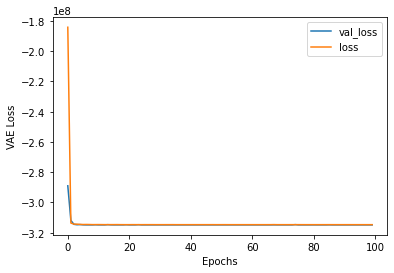

In [47]:
model_a.visualize_training(learning_path)

In [48]:
model_a_weights = model_a.get_decoder_weights()

In [49]:
model_a_compression.to_csv(compress_path, sep='\t', compression='gzip')
model_a.save_models(encoder_path, decoder_path)

In [250]:
def extract_weights(weights, weight_file, k):
    # Multiply hidden layers together to obtain a single representation of gene weights
    intermediate_weight_df = pd.DataFrame(weights[1][0])
    hidden_weight_df = pd.DataFrame(weights[1][2])
    abstracted_weight_df = intermediate_weight_df.dot(hidden_weight_df)

    abstracted_weight_df.index = range(1, k+1)
    abstracted_weight_df.columns = rnaseq_df.columns
    abstracted_weight_df.to_csv(weight_file, sep='\t')

In [51]:
extract_weights(model_a_weights, weight_path)

In [143]:
compress_data = model_a_compression
full_data = rnaseq_df

print(compress_data)
print(full_data)

           1         2         3         4         5         6         7    \
0     0.888610  1.226341  0.000000  0.343611  0.927614  1.464005  0.850590   
1     0.356790  0.141183  0.000000  0.000000  3.369023  0.000000  0.376657   
2     0.500942  0.540359  0.000000  0.876965  0.000000  1.495549  1.472865   
3     0.000000  0.000000  0.655434  0.000000  1.728442  0.000000  0.000000   
4     0.000000  0.000000  0.000000  1.489861  0.000000  1.665756  0.303859   
...        ...       ...       ...       ...       ...       ...       ...   
1101  1.561076  1.591578  0.183055  0.000000  0.686180  0.616508  0.814003   
1102  0.391478  0.177123  1.314176  0.000000  1.144765  0.552964  0.000000   
1103  0.000000  0.000000  0.000000  1.571521  0.000000  0.378635  0.000000   
1104  0.000000  0.000000  1.502662  0.394030  0.835129  0.000000  0.000000   
1105  1.324750  1.692472  0.351112  0.000000  0.135655  0.000000  0.915859   

           8         9         10   ...       91        92     

In [243]:
reconstructed_data = pd.DataFrame(model_a.predict(compress_data))

full_data_check = full_data.drop(['index'], axis=1)

r = [pearsonr(reconstructed_data.iloc[x, :], full_data_check.iloc[x, :])[0] for x in range(full_data.shape[0])]

s = [spearmanr(reconstructed_data.iloc[x, :], full_data_check.iloc[x, :])[0] for x in range(full_data.shape[0])]
print(r)
print(s)



[0.007151864935536554, 0.0074135171681647075, 0.004365055550787185, 0.009082560852392913, 0.005954732115413856, 0.011034765652641547, 0.008192367216028087, 0.004916744108931889, 0.012292887295604474, 0.0077351988070477554, 0.009145686385356048, 0.010833493658387164, 0.005249681873855111, 0.006429108953404661, 0.013227188941730417, 0.0035066263575004447, 0.011675279571442349, 0.009316998487131932, 0.005411127908146138, 0.00676489453069681, 0.011051974226942377, 0.007311496937054261, 0.0074406567186755534, 0.007361796414018524, 0.0078007693427512535, 0.0046977216793658615, 0.004572300183668797, 0.00492734571681453, 0.007881804454476593, 0.003683317974045115, 0.00470531206990497, 0.005621892309909938, 0.003968114705705877, 0.0075456113503951875, 0.009208814191765224, 0.00458862126404957, 0.003789635097753626, 0.0031665985399701745, 0.005448067037560067, 0.011014041648244259, 0.006410215399966035, 0.011530194057197598, 0.005163450485690695, 0.005138859229666115, 0.003908330494441381, 0.005

In [162]:
all_labels = pd.concat([train_label_df, test_label_df], axis=0)
all_labels = pd.DataFrame(np.array(all_labels), columns=['cancer_type'])

print(all_labels)


      cancer_type
0            BRCA
1            LUAD
2            DLBC
3            UCEC
4            SKCM
...           ...
11055        BRCA
11056        PRAD
11057        SKCM
11058        KIRC
11059        BRCA

[11060 rows x 1 columns]


In [163]:
reconstructed_data_label = pd.concat([reconstructed_data, all_labels], axis=1)

In [175]:
compress_data = pd.DataFrame(np.array(compress_data))
compressed_data_label = pd.concat([compress_data, all_labels], axis=1)

In [164]:
full_data_label = pd.concat([full_data.drop(['index'], axis=1), all_labels], axis=1)#.drop(['level_0', 'index'], axis=1)

In [165]:
def runLR(df2, test2):
    time_laps = []
    for i in range(4):
        start_time = time.time()
        clf = LogisticRegression(random_state=0).fit(df2.iloc[:,0:df2.shape[1]],df2["cancer_type"])
        pred = clf.predict(test2.iloc[:,0:test2.shape[1]])
        accuracy = accuracy_score(test2.cancer_type,pred)
        laps = time.time() - start_time
        time_laps.append(laps)
    avg_time_laps = np.mean(time_laps)
    SVM_accuracy = accuracy
    SVM_computation_time = avg_time_laps
    return SVM_accuracy, SVM_computation_time

In [166]:
def returnDf2(c_type, df2):
    fraction = collections.Counter(merge_train)[c_type]/len(merge_train)

    df2_0 = df2[df2.cancer_type!=c_type]
    df2_0.loc[:,"cancer_type"] = 0
    df2_0 = df2_0.sample(frac = fraction)

    df2_1 = df2[df2.cancer_type==c_type]
    df2_1.loc[:,"cancer_type"] = 1
    
    #print(df2_0)
    #print(df2_1)
    
    df2 = pd.concat([df2_0, df2_1])
    df2["cancer_type"] = df2["cancer_type"].astype('int')

    return df2

In [179]:
train_full, test_full = train_test_split(full_data_label, test_size=0.1)
train_compress, test_compress = train_test_split(compressed_data_label, test_size=0.1)
train_reconstructed, test_reconstructed = train_test_split(reconstructed_data_label, test_size=0.1)

In [183]:
c_type_list = collections.Counter(merge_train)
#c_type_list = ['LUAD', 'LGG', 'PRAD', 'STAD']
#c_type_list = ['DLBC']

cols = ['cancer_type', 'Full-data acc.', 'Full-data comp. time','compress acc.','compress comp. time', 'VAE-reconst. acc.', 'VAE-reconst. time.']
results_df = pd.DataFrame(columns = cols)
i = 0
for c_type in c_type_list:
    train_full_ova = returnDf2(c_type, train_full)
    test_full_ova = returnDf2(c_type, test_full)
    train_compress_ova = returnDf2(c_type, train_compress)
    test_compress_ova = returnDf2(c_type, test_compress)
    train_reconstructed_ova = returnDf2(c_type, train_reconstructed)
    test_reconstructed_ova = returnDf2(c_type, test_reconstructed)
    full_acc, full_time = runLR(train_full_ova, test_full_ova)
    compress_acc, compress_time = runLR(train_compress_ova, test_compress_ova)
    full_reconstructed_acc, full_reconstructed_time = runLR(train_reconstructed_ova, test_reconstructed_ova)
    results_df.loc[i] = [c_type, full_acc,full_time,compress_acc,compress_time, full_reconstructed_acc,full_reconstructed_time]
    i = i+1

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

In [184]:
results_df

,cancer_type,Full-data acc.,Full-data comp. time,compress acc.,compress comp. time,VAE-reconst. acc.,VAE-reconst. time.
0,BRCA,0.991266,4.308974,1.000000,0.099232,1.0,3.928997
1,LUAD,1.000000,2.416042,1.000000,0.048371,1.0,2.421776
2,DLBC,1.000000,0.469994,1.000000,0.023437,1.0,0.663726
3,UCEC,0.960396,2.215578,0.990196,0.050864,1.0,2.146263
4,SKCM,0.988889,1.645601,1.000000,0.072805,1.0,1.958764
5,PRAD,0.990741,1.271102,1.000000,0.039395,1.0,2.450449
6,HNSC,0.982456,2.427012,0.990291,0.060588,1.0,2.303841
7,KIRP,0.985294,1.128314,1.000000,0.044880,1.0,1.632386
8,CESC,0.944444,1.635128,1.000000,0.042387,1.0,1.636625
9,THCA,1.000000,1.433667,1.000000,0.101541,1.0,2.422275


MULTICLASS

In [224]:
def prepare_multiclass(c_type_list, df2):
    df_main = df2[df2.cancer_type==c_type_list[0]]
    df_main.loc[:,"cancer_type"] = 0
    
    for i in range(1,len(c_type_list)):
        c_type = c_type_list[i]
        df2_temp = df2[df2.cancer_type==c_type]
        df2_temp.loc[:,"cancer_type"] = i
        df_main = pd.concat([df_main, df2_temp])
        
    df2 = df_main
    df2["cancer_type"] = df2["cancer_type"].astype('int')

    return df2

In [239]:
multi_class_list = ['UCEC', 'HNSC', 'SARC', 'ACC', 'LUSC', 'KIRC', 'PCPG', 'LUAD', 'HNSC', 'COAD']

df2_train_full = prepare_multiclass(multi_class_list, train_full)
df2_test_full = prepare_multiclass(multi_class_list, test_full)
df2_train_compress = prepare_multiclass(multi_class_list, train_compress)
df2_test_compress = prepare_multiclass(multi_class_list, test_compress)
df2_train_reconstructed = prepare_multiclass(multi_class_list, train_reconstructed)
df2_test_reconstructed = prepare_multiclass(multi_class_list, test_reconstructed)

full_acc, full_time = runLR(df2_train_full, df2_test_full)
compress_acc, compress_time = runLR(df2_train_compress, df2_test_compress)
reconstructed_acc, reconstructed_time = runLR(df2_train_reconstructed, df2_test_reconstructed)

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\

In [240]:
print("Full Data- ","\t Acc = ",full_acc,"\t Time = ", full_time)
print("Comp. Data- ","\t Acc = ",compress_acc,"\t Time = ", compress_time)
print("Recon. Data- ","\t Acc = ",reconstructed_acc,"\t Time = ", reconstructed_time)

Full Data-  	 Acc =  0.836405529953917 	 Time =  18.56551480293274
Comp. Data-  	 Acc =  0.9882352941176471 	 Time =  0.6420339941978455
Recon. Data-  	 Acc =  0.9849462365591398 	 Time =  14.962434351444244


Plotting pearson and spearman correlations over number of latent dimensions (K)

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Output "custom_variational_layer_15" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_15" during training.


Train on 9954 samples, validate on 1106 samples
Epoch 1/100
9954/9954 [==============================] - 22s - loss: -28097682.1729 - val_loss: -153526019.1682
Epoch 2/100
9954/9954 [==============================] - 27s - loss: -171791374.9455 - val_loss: -256992145.9675
Epoch 3/100
9954/9954 [==============================] - 19s - loss: -292490989.4507 - val_loss: -303691695.2188
Epoch 4/100
9954/9954 [==============================] - 17s - loss: -310336748.9877 - val_loss: -313033569.9096
Epoch 5/100
9954/9954 [==============================] - 17s - loss: -313772963.1312 - val_loss: -314513880.5931
Epoch 6/100
9954/9954 [==============================] - 17s - loss: -314467683.9285 - val_loss: -314695439.3345
Epoch 7/100
9954/9954 [==============================] - 17s - loss: -314560439.0693 - val_loss: -314765738.6474
Epoch 8/100
9954/9954 [==============================] - 17s - loss: -314608374.2270 - val_loss: -314786064.9548
Epoch 9/100
9954/9954 [==========================

9954/9954 [==============================] - 17s - loss: -314687678.8684 - val_loss: -314852454.8282
Epoch 73/100
9954/9954 [==============================] - 17s - loss: -314687686.1853 - val_loss: -314852466.4014
Epoch 74/100
9954/9954 [==============================] - 17s - loss: -314687671.4872 - val_loss: -314852359.5226
Epoch 75/100
9954/9954 [==============================] - 17s - loss: -314687683.0798 - val_loss: -314852168.5642
Epoch 76/100
9954/9954 [==============================] - 17s - loss: -314687691.0332 - val_loss: -314852466.7486
Epoch 77/100
9954/9954 [==============================] - 17s - loss: -314687595.5925 - val_loss: -314852469.6420
Epoch 78/100
9954/9954 [==============================] - 17s - loss: -314687688.0820 - val_loss: -314852165.6709
Epoch 79/100
9954/9954 [==============================] - 17s - loss: -314687689.2393 - val_loss: -314852472.3617
Epoch 80/100
9954/9954 [==============================] - 17s - loss: -314687670.2335 - val_loss: -31

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Output "custom_variational_layer_16" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_16" during training.


Train on 9954 samples, validate on 1106 samples
Epoch 1/100
9954/9954 [==============================] - 19s - loss: -45549631.9011 - val_loss: -193669948.6293
Epoch 2/100
9954/9954 [==============================] - 17s - loss: -228060525.4282 - val_loss: -281001268.7161
Epoch 3/100
9954/9954 [==============================] - 17s - loss: -305200215.4615 - val_loss: -309053546.8788
Epoch 4/100
9954/9954 [==============================] - 17s - loss: -312029971.7452 - val_loss: -312982758.0759
Epoch 5/100
9954/9954 [==============================] - 18s - loss: -313179896.6253 - val_loss: -313768521.4901
Epoch 6/100
9954/9954 [==============================] - 18s - loss: -313888712.1013 - val_loss: -314423363.1826
Epoch 7/100
9954/9954 [==============================] - 18s - loss: -314166588.2066 - val_loss: -314421199.4503
Epoch 8/100
9954/9954 [==============================] - 18s - loss: -314375765.7834 - val_loss: -314397791.3056
Epoch 9/100
9954/9954 [==========================

9954/9954 [==============================] - 18s - loss: -314687655.8698 - val_loss: -314852516.2821
Epoch 73/100
9954/9954 [==============================] - 18s - loss: -314687705.2747 - val_loss: -314852374.1627
Epoch 74/100
9954/9954 [==============================] - 18s - loss: -314687700.3303 - val_loss: -314852510.1483
Epoch 75/100
9954/9954 [==============================] - 18s - loss: -314687596.5248 - val_loss: -314852512.8680
Epoch 76/100
9954/9954 [==============================] - 18s - loss: -314687615.0098 - val_loss: -314852443.7758
Epoch 77/100
9954/9954 [==============================] - 18s - loss: -314687666.7872 - val_loss: -314852487.0018
Epoch 78/100
9954/9954 [==============================] - 18s - loss: -314687708.4637 - val_loss: -314852481.2152
Epoch 79/100
9954/9954 [==============================] - 18s - loss: -314687722.2745 - val_loss: -314852504.1881
Epoch 80/100
9954/9954 [==============================] - 18s - loss: -314687693.2578 - val_loss: -31

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Output "custom_variational_layer_17" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_17" during training.


Train on 9954 samples, validate on 1106 samples
Epoch 1/100
9954/9954 [==============================] - 20s - loss: -70928764.2099 - val_loss: -256917250.6908
Epoch 2/100
9954/9954 [==============================] - 18s - loss: -273044547.5170 - val_loss: -292573262.4087
Epoch 3/100
9954/9954 [==============================] - 18s - loss: -307308211.9574 - val_loss: -309516164.2242
Epoch 4/100
9954/9954 [==============================] - 18s - loss: -312223036.6502 - val_loss: -312250243.5298
Epoch 5/100
9954/9954 [==============================] - 18s - loss: -313561558.9279 - val_loss: -313627363.3562
Epoch 6/100
9954/9954 [==============================] - 18s - loss: -314066808.6767 - val_loss: -314376291.3562
Epoch 7/100
9954/9954 [==============================] - 18s - loss: -314343460.5329 - val_loss: -314592500.8318
Epoch 8/100
9954/9954 [==============================] - 18s - loss: -314393985.2988 - val_loss: -314560579.4141
Epoch 9/100
9954/9954 [==========================

9954/9954 [==============================] - 18s - loss: -314687556.0828 - val_loss: -314852498.7486
Epoch 73/100
9954/9954 [==============================] - 18s - loss: -314687582.8684 - val_loss: -314852504.7089
Epoch 74/100
9954/9954 [==============================] - 18s - loss: -314687607.5387 - val_loss: -314852333.8300
Epoch 75/100
9954/9954 [==============================] - 18s - loss: -314687724.9749 - val_loss: -314852516.2821
Epoch 76/100
9954/9954 [==============================] - 18s - loss: -314687712.9902 - val_loss: -314852521.8951
Epoch 77/100
9954/9954 [==============================] - 18s - loss: -314687709.2867 - val_loss: -314852513.0416
Epoch 78/100
9954/9954 [==============================] - 18s - loss: -314687005.5568 - val_loss: -314852513.5624
Epoch 79/100
9954/9954 [==============================] - 18s - loss: -314687652.0185 - val_loss: -314852519.0018
Epoch 80/100
9954/9954 [==============================] - 18s - loss: -314679312.9805 - val_loss: -31

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Output "custom_variational_layer_18" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_18" during training.


Train on 9954 samples, validate on 1106 samples
Epoch 1/100
9954/9954 [==============================] - 20s - loss: -100207013.6575 - val_loss: -258147206.4231
Epoch 2/100
9954/9954 [==============================] - 18s - loss: -298590706.2664 - val_loss: -304703137.9096
Epoch 3/100
9954/9954 [==============================] - 18s - loss: -311571985.0834 - val_loss: -312503557.4394
Epoch 4/100
9954/9954 [==============================] - 18s - loss: -313138241.3116 - val_loss: -312735841.7939
Epoch 5/100
9954/9954 [==============================] - 18s - loss: -314061368.8953 - val_loss: -314624649.8373
Epoch 6/100
9954/9954 [==============================] - 18s - loss: -314187238.4746 - val_loss: -314637617.4177
Epoch 7/100
9954/9954 [==============================] - 18s - loss: -314390763.8561 - val_loss: -314348689.3020
Epoch 8/100
9954/9954 [==============================] - 18s - loss: -314492430.1258 - val_loss: -314768334.9873
Epoch 9/100
9954/9954 [=========================

9954/9954 [==============================] - 17s - loss: -314671576.1945 - val_loss: -314852545.5624
Epoch 73/100
9954/9954 [==============================] - 17s - loss: -314687457.2538 - val_loss: -314852536.1881
Epoch 74/100
9954/9954 [==============================] - 17s - loss: -314687736.3745 - val_loss: -314852519.5226
Epoch 75/100
9954/9954 [==============================] - 17s - loss: -314686554.9206 - val_loss: -314852455.6962
Epoch 76/100
9954/9954 [==============================] - 17s - loss: -314687649.6910 - val_loss: -314852527.8553
Epoch 77/100
9954/9954 [==============================] - 17s - loss: -314687628.3126 - val_loss: -314852516.4557
Epoch 78/100
9954/9954 [==============================] - 17s - loss: -314687724.6277 - val_loss: -314811333.2658
Epoch 79/100
9954/9954 [==============================] - 17s - loss: -314687722.6217 - val_loss: -314852531.2694
Epoch 80/100
9954/9954 [==============================] - 17s - loss: -314687750.4103 - val_loss: -31

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Output "custom_variational_layer_19" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_19" during training.


Train on 9954 samples, validate on 1106 samples
Epoch 1/100
9954/9954 [==============================] - 20s - loss: -154388342.5398 - val_loss: -289768400.9837
Epoch 2/100
9954/9954 [==============================] - 18s - loss: -310487084.9170 - val_loss: -309591870.6112
Epoch 3/100
9954/9954 [==============================] - 18s - loss: -313493501.6789 - val_loss: -313925811.1537
Epoch 4/100
9954/9954 [==============================] - 18s - loss: -313985611.0782 - val_loss: -314200848.7233oss: -314003790.22
Epoch 5/100
9954/9954 [==============================] - 18s - loss: -314309134.4344 - val_loss: -314586326.3363
Epoch 6/100
9954/9954 [==============================] - 18s - loss: -314408393.9208 - val_loss: -314835124.2532
Epoch 7/100
9954/9954 [==============================] - 18s - loss: -314408423.6833 - val_loss: -314661867.1103
Epoch 8/100
9954/9954 [==============================] - 18s - loss: -314628547.0026 - val_loss: -314830833.4756
Epoch 9/100
9954/9954 [=======

9954/9954 [==============================] - 18s - loss: -314686600.0305 - val_loss: -314852539.6022
Epoch 73/100
9954/9954 [==============================] - 18s - loss: -314687757.2385 - val_loss: -314852513.7360
Epoch 74/100
9954/9954 [==============================] - 18s - loss: -314687756.1905 - val_loss: -314852548.1085
Epoch 75/100
9954/9954 [==============================] - 18s - loss: -314682439.8762 - val_loss: -314852548.4557
Epoch 76/100
9954/9954 [==============================] - 17s - loss: -314687753.9337 - val_loss: -314852539.7758
Epoch 77/100
9954/9954 [==============================] - 17s - loss: -314687758.2029 - val_loss: -314852542.4955
Epoch 78/100
9954/9954 [==============================] - 17s - loss: -314682281.1557 - val_loss: -314852004.5136
Epoch 79/100
9954/9954 [==============================] - 18s - loss: -314687757.4314 - val_loss: -314851587.7034
Epoch 80/100
9954/9954 [==============================] - 18s - loss: -314687765.1147 - val_loss: -31

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Output "custom_variational_layer_20" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_20" during training.


Train on 9954 samples, validate on 1106 samples
Epoch 1/100
9954/9954 [==============================] - 21s - loss: -190338656.1395 - val_loss: -287328449.0995
Epoch 2/100
9954/9954 [==============================] - 18s - loss: -313473028.4300 - val_loss: -312054697.6058
Epoch 3/100
9954/9954 [==============================] - 18s - loss: -314272337.4627 - val_loss: -314349823.3635
Epoch 4/100
9954/9954 [==============================] - 18s - loss: -314368875.3611 - val_loss: -314290551.0307
Epoch 5/100
9954/9954 [==============================] - 18s - loss: -314492370.0607 - val_loss: -314650331.1392
Epoch 6/100
9954/9954 [==============================] - 18s - loss: -314568675.0733 - val_loss: -314654717.3960
Epoch 7/100
9954/9954 [==============================] - 18s - loss: -314610830.2672 - val_loss: -314851986.1121
Epoch 8/100
9954/9954 [==============================] - 18s - loss: -314623652.8865 - val_loss: -314851925.5262
Epoch 9/100
9954/9954 [=========================

9954/9954 [==============================] - 18s - loss: -314684541.5053 - val_loss: -314852524.6148
Epoch 73/100
9954/9954 [==============================] - 18s - loss: -314657695.0549 - val_loss: -314852513.0416
Epoch 74/100
9954/9954 [==============================] - 18s - loss: -314683391.2349 - val_loss: -314766266.2134
Epoch 75/100
9954/9954 [==============================] - 18s - loss: -314684678.8989 - val_loss: -314852530.2278
Epoch 76/100
9954/9954 [==============================] - 18s - loss: -314680213.3269 - val_loss: -314852530.4014
Epoch 77/100
9954/9954 [==============================] - 18s - loss: -314687750.6096 - val_loss: -314852466.5750033.
Epoch 78/100
9954/9954 [==============================] - 18s - loss: -314687678.6305 - val_loss: -314852532.9476
Epoch 79/100
9954/9954 [==============================] - 18s - loss: -314687749.0215 - val_loss: -314852533.1212
Epoch 80/100
9954/9954 [==============================] - 18s - loss: -314687641.3904 - val_loss:

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Output "custom_variational_layer_21" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_21" during training.


Train on 9954 samples, validate on 1106 samples
Epoch 1/100
9954/9954 [==============================] - 21s - loss: -208721246.0237 - val_loss: -296140897.6203
Epoch 2/100
9954/9954 [==============================] - 18s - loss: -314194270.6434 - val_loss: -312596182.8571
Epoch 3/100
9954/9954 [==============================] - 18s - loss: -314478047.7107 - val_loss: -314455755.3996
Epoch 4/100
9954/9954 [==============================] - 18s - loss: -314523284.1567 - val_loss: -314787893.5262
Epoch 5/100
9954/9954 [==============================] - 18s - loss: -314568123.7822 - val_loss: -314820507.0814
Epoch 6/100
9954/9954 [==============================] - 18s - loss: -314600964.0571 - val_loss: -314841848.1302
Epoch 7/100
9954/9954 [==============================] - 17s - loss: -314614544.2025 - val_loss: -314850065.1284
Epoch 8/100
9954/9954 [==============================] - 17s - loss: -314637278.1869 - val_loss: -314796553.3743
Epoch 9/100
9954/9954 [=========================

9954/9954 [==============================] - 18s - loss: -314687745.8260 - val_loss: -314852524.6148
Epoch 73/100
9954/9954 [==============================] - 18s - loss: -314687738.5670 - val_loss: -314852515.7613
Epoch 74/100
9954/9954 [==============================] - 18s - loss: -314687741.6339 - val_loss: -314852536.1881
Epoch 75/100
9954/9954 [==============================] - 19s - loss: -314687742.2061 - val_loss: -314852524.9620
Epoch 76/100
9954/9954 [==============================] - 18s - loss: -314687743.8650 - val_loss: -314852527.5081
Epoch 77/100
9954/9954 [==============================] - 18s - loss: -314687742.2319 - val_loss: -314852533.2948
Epoch 78/100
9954/9954 [==============================] - 18s - loss: -314687741.8525 - val_loss: -314852524.6148
Epoch 79/100
9954/9954 [==============================] - 18s - loss: -314687742.7334 - val_loss: -314852524.9620
Epoch 80/100
9954/9954 [==============================] - 18s - loss: -314687746.5011 - val_loss: -31

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Output "custom_variational_layer_22" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_22" during training.


Train on 9954 samples, validate on 1106 samples
Epoch 1/100
9954/9954 [==============================] - 22s - loss: -220251356.6056 - val_loss: -297294933.3526
Epoch 2/100
9954/9954 [==============================] - 18s - loss: -314484726.9279 - val_loss: -312827964.2387
Epoch 3/100
9954/9954 [==============================] - 18s - loss: -314469848.1109 - val_loss: -314476914.8644
Epoch 4/100
9954/9954 [==============================] - 18s - loss: -314581056.4051 - val_loss: -314823897.8662
Epoch 5/100
9954/9954 [==============================] - 18s - loss: -314608064.0321 - val_loss: -314583122.6329
Epoch 6/100
9954/9954 [==============================] - 18s - loss: -314644567.2686 - val_loss: -314819705.6347
Epoch 7/100
9954/9954 [==============================] - 18s - loss: -314671255.8087 - val_loss: -314852098.7776
Epoch 8/100
9954/9954 [==============================] - 18s - loss: -314679426.3597 - val_loss: -314831828.6004
Epoch 9/100
9954/9954 [=========================

9954/9954 [==============================] - 18s - loss: -314687242.4352 - val_loss: -314852521.7215
Epoch 73/100
9954/9954 [==============================] - 18s - loss: -314684524.9234 - val_loss: -314852521.7215
Epoch 74/100
9954/9954 [==============================] - 18s - loss: -314687738.4641 - val_loss: -314852527.5081
Epoch 75/100
9954/9954 [==============================] - 18s - loss: -314687478.7350 - val_loss: -314852530.4014
Epoch 76/100
9954/9954 [==============================] - 19s - loss: -314687733.7834 - val_loss: -314852518.4810
Epoch 77/100
9954/9954 [==============================] - 18s - loss: -314687737.5961 - val_loss: -314852518.8282
Epoch 78/100
9954/9954 [==============================] - 18s - loss: -314687739.5186 - val_loss: -314852524.6148
Epoch 79/100
9954/9954 [==============================] - 18s - loss: -314687740.5473 - val_loss: -314852521.7215
Epoch 80/100
9954/9954 [==============================] - 18s - loss: -314687742.4119 - val_loss: -31

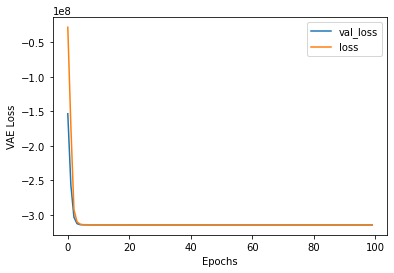

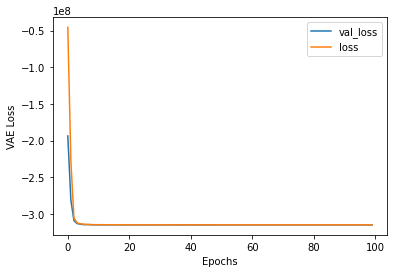

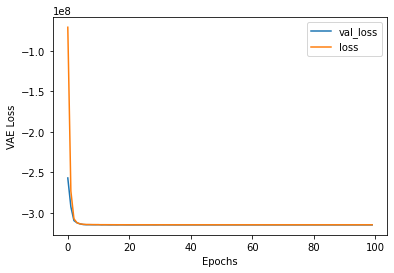

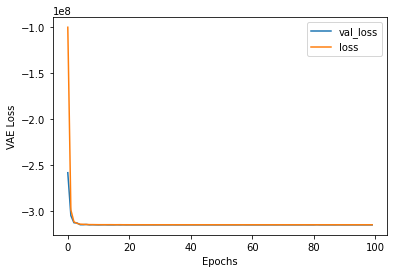

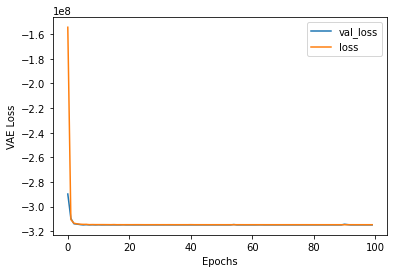

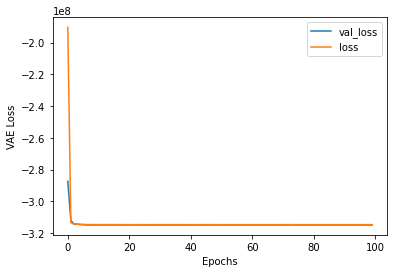

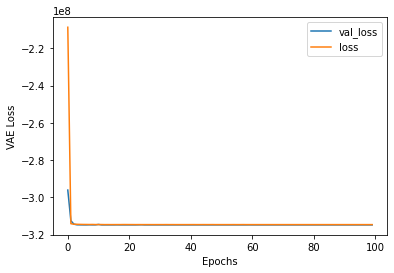

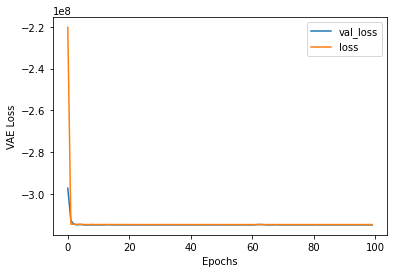

In [277]:
list_k = [2, 5, 10, 20, 50, 100, 150, 200]

list_pearson = []
list_spearman = []

for k in list_k:
    # Set common hyper parameters
    rnaseq_train_df = train_tcga_df.drop(['cancer_type', 'sample_id'], axis=1)
    rnaseq_test_df = test_tcga_df.drop(['cancer_type', 'sample_id'], axis=1)

    original_dim = rnaseq_train_df.shape[1]
    latent_dim = k
    beta = K.variable(0)
    epsilon_std = 1.0

    # Model A (100 hidden layer size)
    model_a_latent_dim = 100
    model_a_batch_size = 100
    model_a_epochs = 100
    model_a_learning_rate = 0.001
    model_a_kappa = 1.0
    
    model_a = Tybalt(original_dim=original_dim,
                 hidden_dim=model_a_latent_dim,
                 latent_dim=latent_dim,
                 batch_size=model_a_batch_size,
                 epochs=model_a_epochs,
                 learning_rate=model_a_learning_rate,
                 kappa=model_a_kappa,
                 beta=beta)
    
    # Compile Model A
    model_a.build_encoder_layer()
    model_a.build_decoder_layer()
    model_a.compile_vae()
    
    model_a.train_vae()
    
    rnaseq_df = pd.concat([rnaseq_train_df, rnaseq_test_df])

    model_a_compression = model_a.compress(rnaseq_df)
    
    learning_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/figure/k_'+str(k)+'_epoch_100_learning.pdf'
    compress_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/models/k_'+str(k)+'_epoch_100_compress.tsv'
    encoder_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/models/k_'+str(k)+'_epoch_100_encoder_twohidden100_vae.hdf5'
    decoder_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/models/k_'+str(k)+'_epoch_100_decoder_twohidden100_vae.hdf5'
    weight_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/models/k_'+str(k)+'_epoch_100_enc_dec_weights.tsv'
    
    model_a.visualize_training(learning_path)
    
    model_a_weights = model_a.get_decoder_weights()
    
    model_a_compression.to_csv(compress_path, sep='\t', compression='gzip')
    model_a.save_models(encoder_path, decoder_path)
    
    extract_weights(model_a_weights, weight_path, k)
    
    compress_data = model_a_compression
    full_data = rnaseq_df
    
    reconstructed_data = pd.DataFrame(model_a.predict(compress_data))

    full_data_check = full_data#.drop(['index'], axis=1)

    r = [pearsonr(reconstructed_data.iloc[x, :], full_data_check.iloc[x, :])[0] for x in range(full_data.shape[0])]

    s = [spearmanr(reconstructed_data.iloc[x, :], full_data_check.iloc[x, :])[0] for x in range(full_data.shape[0])]
    
    list_pearson.append(r)
    list_spearman.append(s)

In [298]:
# specific cancer type selection
list_label = np.array(all_labels)
c_type_list = collections.Counter(merge_train)

for c_type in c_type_list:
    pearson_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/figure/c_type_vae/fig__pearson_'+c_type+'.png'
    spearman_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/figure/c_type_vae/fig__spearman_'+c_type+'.png'
    c_pearson = []
    c_spearman = []
    for i in range(len(list_label)):
        if c_type == list_label[i]:
            c_pearson.append(list_pearson[:,i])
            c_spearman.append(list_spearman[:,i])

    c_pearson = np.array(c_pearson)
    c_spearman = np.array(c_spearman)

    fig, ax = plt.subplots() 
    fig.suptitle('Box plot for '+str(c_type)) 
    ax.set_xlabel('Values of k') 
    ax.set_ylabel('Peason Corr.') 
    ax.boxplot(c_pearson, labels=list_k) 
    fig.savefig(pearson_path)
    fig.clear(True) 


    fig2, ax2 = plt.subplots() 
    fig2.suptitle('Box plot for '+str(c_type)) 
    ax2.set_xlabel('Values of k') 
    ax2.set_ylabel('Spearman Corr.') 
    ax2.boxplot(c_spearman, labels=list_k) 
    fig2.savefig(spearman_path)
    fig2.clear(True)

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control

C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\RUSHI\Anaconda Python\envs\tf1\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Pearson (K=2 to 50)

ACC
GBM
KICH
KIRC
KIRP
LGG

Spearman (K=2 to 50)

ACC
GBM
KICH
KIRC
KIRP
LGG

In [301]:
clean_classes = ['ACC', 'GBM', 'KICH', 'KIRC', 'KIRP', 'LGG']
list_label = np.array(all_labels)
clean_k_list = [2, 5, 10, 20, 50]

for c_type in clean_classes:
    pearson_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/figure/c_type_vae/select/fig__pearson_'+c_type+'.png'
    spearman_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/figure/c_type_vae/select/fig__spearman_'+c_type+'.png'
    c_pearson = []
    c_spearman = []
    for i in range(len(list_label)):
        if c_type == list_label[i]:
            c_pearson.append(list_pearson[:,i])
            c_spearman.append(list_spearman[:,i])

    c_pearson = np.array(c_pearson)
    c_spearman = np.array(c_spearman)
    
    c_pearson_select = c_pearson[:,:5]
    c_spearman_select = c_spearman[:,:5]
    
    fig, ax = plt.subplots() 
    fig.suptitle('Box plot for '+str(c_type)) 
    ax.set_xlabel('Values of k') 
    ax.set_ylabel('Peason Corr.') 
    ax.boxplot(c_pearson_select, labels=clean_k_list) 
    fig.savefig(pearson_path)
    fig.clear(True) 


    fig2, ax2 = plt.subplots() 
    fig2.suptitle('Box plot for '+str(c_type)) 
    ax2.set_xlabel('Values of k') 
    ax2.set_ylabel('Spearman Corr.') 
    ax2.boxplot(c_spearman_select, labels=clean_k_list) 
    fig2.savefig(spearman_path)
    fig2.clear(True)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [278]:
list_pearson = np.array(list_pearson)
list_spearman = np.array(list_spearman)
print(np.mean(list_pearson, axis=1))
print(np.mean(list_spearman, axis=1))

[0.00753697 0.00785365 0.00771309 0.00759386 0.00722426 0.00647226
 0.0064431  0.00647387]
[0.06514269 0.07482322 0.08037008 0.07895613 0.07759474 0.07426682
 0.07105359 0.06978897]


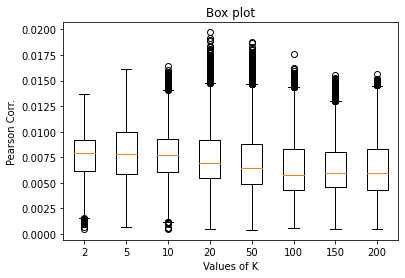

In [279]:
plt.title('Box plot')
plt.xlabel('Values of K')
plt.ylabel('Pearson Corr.')
plt.boxplot(list_pearson.transpose(), labels=list_k)
plt.show()

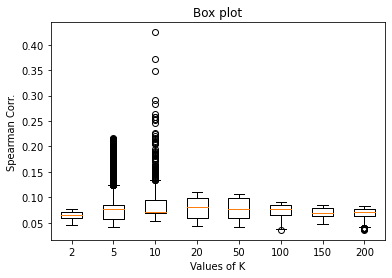

In [280]:
plt.title('Box plot')

plt.xlabel('Values of K')
plt.ylabel('Spearman Corr.')
plt.boxplot(list_spearman.transpose(), labels=list_k)
plt.show()

RECONSTRUCTION LOSS CALCULATION OVER K

In [338]:
def approx_keras_binary_cross_entropy(x, z, p, epsilon=1e-07):
    """
    Arguments:
    x - Reconstructed input RNAseq data
    z - Input RNAseq data
    p - number of features
    epsilon - the clipping value to stabilize results (same Keras default)
    """
    # Ensure numpy arrays
    x = np.array(x)
    z = np.array(z)

    # Add clip to value
    x[x < epsilon] = epsilon
    x[x > (1 - epsilon)] = (1 - epsilon)

    # Perform logit
    x = np.log(x / (1 - x))

    # Return approximate binary cross entropy
    return np.mean(p * np.mean(- x * z + np.log(1 + np.exp(x)), axis=-1))


In [354]:
list_k = [2, 5, 10, 20, 50, 100, 150, 200]

rnaseq_train_df = train_tcga_df.drop(['cancer_type', 'sample_id'], axis=1)
rnaseq_test_df = test_tcga_df.drop(['cancer_type', 'sample_id'], axis=1)

rnaseq_merged = pd.concat([rnaseq_train_df, rnaseq_test_df])
input_data = np.array(rnaseq_merged)

mse_list = []
bce_list = []

for k in list_k:
    learning_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/figure/k_'+str(k)+'_epoch_100_learning.pdf'
    compress_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/models/k_'+str(k)+'_epoch_100_compress.tsv'
    encoder_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/models/k_'+str(k)+'_epoch_100_encoder_twohidden100_vae.hdf5'
    decoder_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/models/k_'+str(k)+'_epoch_100_decoder_twohidden100_vae.hdf5'
    weight_path = 'D://GitHub/Gene-compression-and-Cancer-type-classification/models/k_'+str(k)+'_epoch_100_enc_dec_weights.tsv'

    enc_model = load_model(encoder_path)
    dec_model = load_model(decoder_path)
    
#     with open(compress_path, 'rb') as fd:
#         gzip_fd = gzip.GzipFile(fileobj=fd)
#         compress_data = pd.read_csv(gzip_fd, sep='\t')
    
#     compress_data = compress_data.drop(compress_data.columns[0], axis=1)    
    
    compress_data = enc_model.predict(input_data)
    
    reconstructed_data = dec_model.predict(np.array(compress_data))

    mse = np.sum((input_data - reconstructed_data) ** 2, axis=1).mean()
    bce = approx_keras_binary_cross_entropy(reconstructed_data, input_data, k)
    
    mse_list.append(mse)
    bce_list.append(bce)

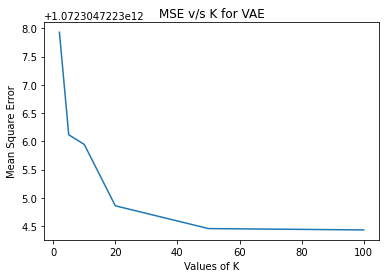

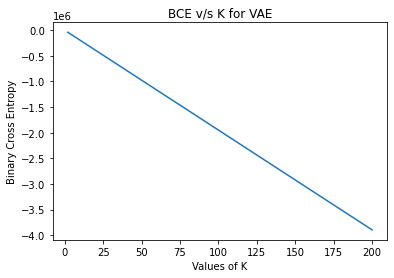

In [365]:
plt.title('MSE v/s K for VAE')
plt.xlabel('Values of K')
plt.ylabel('Mean Square Error')
plt.plot(list_k[:6], mse_list[:6])
plt.show()

plt.title('BCE v/s K for VAE')
plt.xlabel('Values of K')
plt.ylabel('Binary Cross Entropy')
plt.plot(list_k, bce_list)
plt.show()